### **Problem**

This project aims to automate multi-label classification of disaster-related tweets using advanced natural language processing (NLP) models. The tweets, collected during hurricane events such as Harvey, Imelda, and Beryl, contain critical information ranging from property damage to requests for assistance. Manual annotation of such large-scale data is infeasible and time-consuming. Hence, there is a need for an efficient and scalable method to identify multiple categories of disaster impact from tweet content, enabling timely and informed disaster response decisions.

---

### **Objectives**

* Understand the underlying structure of multi-label text classification.
* Implement a custom PyTorch dataset and data preprocessing pipeline using geolocation and tweet metadata.
* Train a BERT-based multi-head neural network to predict 11 disaster impact categories.
* Apply k-fold cross-validation to ensure robust model evaluation.
* Use ensemble modeling strategies (in-domain, cross-domain, two-source, and three-source) to analyze model generalization across different hurricanes.
* Generate performance metrics such as Accuracy, Precision, Recall, and F1-Score for each label and average performance.
* Save the best model per fold and use ensemble predictions to improve reliability.



### 1. Import Required Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import math

This imports all necessary libraries:
- `os` for file operations
- `torch` for deep learning framework
- `transformers` for BERT model
- `Dataset` and `DataLoader` for handling data
- `KFold` for cross-validation
- Metrics from `sklearn` for evaluation
- `pandas` and `numpy` for data handling
- `tqdm` for progress bars
- `math` for geolocation calculations


### 2. Set Device and Reproducibility Seed

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(64)

- Sets the device to GPU if available, otherwise CPU
- Fixes random seed (64) for reproducibility

### 3. Define Save Path for Model Outputs


In [4]:
save_path = 'Training_results/Harvey_5foldcv_BERT_Multihead_Deeper_512/'
os.makedirs(save_path, exist_ok=True)

- Defines where to save model checkpoints and results
- Creates directory if it doesn't exist

### 4. Load BERT Tokenizer and Model


In [5]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = transformers.BertModel.from_pretrained('bert-base-uncased')

- Loads BERT tokenizer and base model (uncased version)
- Will be used for text processing and feature extraction

### 5. Define Geolocation Utility Functions

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3959  
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_box_area(lat1, lon1, lat2, lon2):
    side1 = haversine(lat1, lon1, lat1, lon2)
    side2 = haversine(lat1, lon1, lat2, lon1)
    return side1 * side2

- `haversine()` calculates distance between two geographic points
- `get_box_area()` computes area of a bounding box
- Used for filtering tweets by spatial relevance

### 6. Define Default Target List

In [7]:
def get_target_list(target_list=[]):
    if not target_list:
        target_list = [
            'homeOwnersInsurance', 'floodInsurance', 'destroyed', 'floodDamage', 'roofDamage', 
            'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
            'replacementAssistanceEligible', 'personalPropertyEligible'
        ]
    return target_list

- Returns list of 11 disaster impact categories
- Used for multi-label classification

### 7. Define Custom Dataset Class

In [8]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

- Handles tokenization and formatting of text data
- Converts text to BERT-compatible input format
- Returns dictionary with input IDs, attention masks, and labels

### 8. Define BERT Multi-Head Classification Model


In [9]:
class BERTMultiDeepHeadClassifier(nn.Module):
    def __init__(self, num_targets=11):
        super(BERTMultiDeepHeadClassifier, self).__init__()
        self.bert = model_bert
        self.drop = nn.Dropout(0.3)
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.bert.config.hidden_size, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 1),
                nn.Sigmoid()
            ) for _ in range(num_targets)
        ])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.drop(outputs.pooler_output)
        return torch.cat([head(pooled_output) for head in self.heads], dim=1)

- Custom BERT model with separate deep heads for each target
- Each head has 3 linear layers with ReLU activation and dropout
- Final sigmoid activation for binary classification

### 9. Define K-Fold Cross-Validation Training Function

In [12]:
def kfoldcv(grouped_tweets, grouped_targets, target_list=[], max_len=256, batch_size=32, num_epochs=10, patience=15):
    saved_models = []
    target_list = get_target_list(target_list)
    
    tweet_dict = {int(name): group['text'] for name, group in grouped_tweets}
    target_dict = {int(name): group[target_list] for name, group in grouped_targets}
    
    intersecting_zips = list(set(target_dict.keys()) & set(tweet_dict.keys()))
    paired_data = {
        name: [target_dict[name].sum().apply(lambda x: 1 if x > 0 else 0), tweet_dict[name]] for name in intersecting_zips
    }
    
    texts = ['\n'.join(v[1].to_list()) for v in paired_data.values()]
    labels_ = [v[0] for v in paired_data.values()]
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    best_f1 = -float('inf')
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(texts, labels_)):
        print(f"Training fold {fold + 1}...")

        X_train, X_test = [texts[i] for i in train_idx], [texts[i] for i in test_idx]
        y_train, y_test = [labels_[i] for i in train_idx], [labels_[i] for i in test_idx]
        
        train_dataset = CustomDataset(X_train, y_train, tokenizer, max_len)
        test_dataset = CustomDataset(X_test, y_test, tokenizer, max_len)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = BERTMultiDeepHeadClassifier(num_targets=len(target_list)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        criterion = nn.BCELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
        
        early_stop_count = 0
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch_f1 = 0
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            train_preds, train_labels = [], []
            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
                for batch in tepoch:
                    optimizer.zero_grad()
                    
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids, attention_mask)
                    loss = sum([criterion(outputs[:, i], labels[:, i]) for i in range(len(target_list))])
                    
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    
                    tepoch.set_postfix(loss=loss.item())
                    
                    train_preds.append(outputs.detach().cpu().numpy())
                    train_labels.append(labels.cpu().numpy())
            
            train_preds = np.vstack(train_preds)
            train_labels = np.vstack(train_labels)
            
            model.eval()
            val_loss = 0
            val_preds, val_labels = [], []
            
            with torch.no_grad():
                for batch in tqdm(test_loader, desc="Validating", unit="batch"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids, attention_mask)
                    loss = sum([criterion(outputs[:, i], labels[:, i]) for i in range(len(target_list))])
                    
                    val_loss += loss.item()
                    val_preds.append(outputs.cpu().numpy())
                    val_labels.append(labels.cpu().numpy())
            
            val_preds = np.vstack(val_preds)
            val_labels = np.vstack(val_labels)
            
            f1 = np.mean([f1_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            accuracy = np.mean([accuracy_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            precision = np.mean([precision_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            recall = np.mean([recall_score(val_labels[:, i], val_preds[:, i] > 0.5) for i in range(len(target_list))])
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
            
            scheduler.step(f1)
            
            if f1 > best_epoch_f1:
                best_epoch_f1 = f1
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count >= patience:
                    print("Early stopping triggered.")
                    break
        
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), os.path.join(save_path, f"bert_model_fold_{fold+1}.pth"))
        saved_models.append(model)

- Implements 5-fold cross-validation
- Trains separate model for each fold
- Uses early stopping based on validation F1 score
- Saves best model for each fold

### 10. Load and Preprocess Data & Start Training

In [13]:
size_threshold = 80

# Load and preprocess Harvey tweets
tweets_harvey2 = pd.read_csv('harvey_corrected.csv')
tweets_harvey2.rename(columns={'zipcode': 'zip_code'}, inplace=True)

# Filter tweets by geographic relevance
bboxes_useful = tweets_harvey2.place_bbox.apply(lambda x: [[float(i.strip('()[]')) for i in x.split(', ')][i] for i in [1,0,3,2]])
bbu_areas = bboxes_useful.apply(lambda x: get_box_area(*x))
tweets_harvey = tweets_harvey2.loc[((tweets_harvey2.geo.apply(lambda x: 'Point' in str(x))) | (bbu_areas < size_threshold)), :]
tweets_harvey.loc[:, 'zip_code'] = tweets_harvey['zip_code'].apply(int)
tweet_grouped_harvey = tweets_harvey.groupby('zip_code')

# Load target data
targets_harvey = pd.read_csv('disaster_4332.csv')
target_grouped_harvey = targets_harvey.groupby('damagedZipCode')

# Start training
kfoldcv(tweet_grouped_harvey, target_grouped_harvey, max_len=512, batch_size=24, num_epochs=100)

/tmp/job.15628756/ipykernel_3227250/3791959303.py:15: DtypeWarning: Columns (9,10,13,28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  targets_harvey = pd.read_csv('disaster_4332.csv')


Training fold 1...


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.90batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 1: Train Loss: 104.1477, Val Loss: 29.2008, F1: 0.6401, Accuracy: 0.6796, Precision: 0.5284, Recall: 0.8164


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.91batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 2: Train Loss: 100.9657, Val Loss: 28.3476, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 3: Train Loss: 98.7795, Val Loss: 27.7018, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.93batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 4: Train Loss: 97.3041, Val Loss: 27.2752, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.93batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 5: Train Loss: 96.0091, Val Loss: 27.0112, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.93batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 6: Train Loss: 95.2778, Val Loss: 26.9377, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 7: Train Loss: 95.1130, Val Loss: 26.8988, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 8: Train Loss: 94.2566, Val Loss: 26.8664, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 9: Train Loss: 94.2451, Val Loss: 26.8231, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 10: Train Loss: 94.4593, Val Loss: 26.7914, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 11: Train Loss: 93.4455, Val Loss: 26.7907, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 12: Train Loss: 93.0848, Val Loss: 26.7952, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 13: Train Loss: 93.0391, Val Loss: 26.7250, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 14: Train Loss: 93.0664, Val Loss: 26.6589, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 15: Train Loss: 91.5979, Val Loss: 26.5976, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.94batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 16: Train Loss: 91.8625, Val Loss: 26.5506, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.93batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 17: Train Loss: 91.5258, Val Loss: 26.5094, F1: 0.6409, Accuracy: 0.6807, Precision: 0.5288, Recall: 0.8182
Early stopping triggered.
Training fold 2...


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 1: Train Loss: 103.7086, Val Loss: 28.7496, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 2: Train Loss: 101.0656, Val Loss: 27.8713, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 3: Train Loss: 99.2978, Val Loss: 27.2336, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 4: Train Loss: 98.0417, Val Loss: 26.7431, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 5: Train Loss: 97.0606, Val Loss: 26.5593, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 6: Train Loss: 95.8997, Val Loss: 26.4057, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 7: Train Loss: 95.8103, Val Loss: 26.2831, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 8: Train Loss: 95.6007, Val Loss: 26.2281, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 9: Train Loss: 95.3550, Val Loss: 26.1722, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 10: Train Loss: 95.2277, Val Loss: 26.1253, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 11: Train Loss: 95.3343, Val Loss: 26.1041, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 12: Train Loss: 95.3294, Val Loss: 26.0817, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 13: Train Loss: 94.7380, Val Loss: 26.0651, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 14: Train Loss: 94.3300, Val Loss: 26.0554, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 15: Train Loss: 95.1538, Val Loss: 26.0434, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 16: Train Loss: 94.8341, Val Loss: 26.0328, F1: 0.6546, Accuracy: 0.6951, Precision: 0.5477, Recall: 0.8182
Early stopping triggered.
Training fold 3...


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 1: Train Loss: 105.6235, Val Loss: 29.3320, F1: 0.6027, Accuracy: 0.6807, Precision: 0.5161, Recall: 0.7258


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 2: Train Loss: 102.5986, Val Loss: 28.3823, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 3: Train Loss: 100.0467, Val Loss: 27.7193, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 4: Train Loss: 98.8102, Val Loss: 27.1561, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 5: Train Loss: 96.8183, Val Loss: 26.8064, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 6: Train Loss: 96.2286, Val Loss: 26.6353, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 7: Train Loss: 95.8733, Val Loss: 26.6270, F1: 0.6767, Accuracy: 0.7140, Precision: 0.5776, Recall: 0.8182


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 8: Train Loss: 94.9690, Val Loss: 26.6692, F1: 0.6748, Accuracy: 0.7184, Precision: 0.5892, Recall: 0.7913


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9: Train Loss: 93.0055, Val Loss: 27.0262, F1: 0.6662, Accuracy: 0.7062, Precision: 0.6315, Recall: 0.7079


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 10: Train Loss: 91.4896, Val Loss: 26.5962, F1: 0.6593, Accuracy: 0.7040, Precision: 0.5953, Recall: 0.7396


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 11: Train Loss: 90.3799, Val Loss: 26.4351, F1: 0.6565, Accuracy: 0.7007, Precision: 0.5949, Recall: 0.7333


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 12: Train Loss: 88.8329, Val Loss: 26.4570, F1: 0.6724, Accuracy: 0.7395, Precision: 0.6442, Recall: 0.7035


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 13: Train Loss: 87.5608, Val Loss: 26.2242, F1: 0.6670, Accuracy: 0.7262, Precision: 0.6257, Recall: 0.7148


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 14: Train Loss: 86.5858, Val Loss: 26.2053, F1: 0.6708, Accuracy: 0.7361, Precision: 0.6399, Recall: 0.7052


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 15: Train Loss: 85.4056, Val Loss: 26.1653, F1: 0.6713, Accuracy: 0.7373, Precision: 0.6409, Recall: 0.7052


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 16: Train Loss: 85.0698, Val Loss: 26.0863, F1: 0.6698, Accuracy: 0.7339, Precision: 0.6367, Recall: 0.7068


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 17: Train Loss: 84.4806, Val Loss: 26.0449, F1: 0.6716, Accuracy: 0.7361, Precision: 0.6374, Recall: 0.7100
Early stopping triggered.
Training fold 4...


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 1: Train Loss: 104.8547, Val Loss: 29.2418, F1: 0.6299, Accuracy: 0.6577, Precision: 0.5147, Recall: 0.8163


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 2: Train Loss: 101.8540, Val Loss: 28.4427, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 3: Train Loss: 99.3114, Val Loss: 27.8017, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 4: Train Loss: 98.2408, Val Loss: 27.3528, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 5: Train Loss: 96.3622, Val Loss: 27.0557, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 6: Train Loss: 95.6501, Val Loss: 26.9494, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 7: Train Loss: 94.9482, Val Loss: 26.8642, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 8: Train Loss: 94.8093, Val Loss: 26.8024, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 9: Train Loss: 94.2792, Val Loss: 26.7746, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 10: Train Loss: 93.8805, Val Loss: 26.7541, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 11: Train Loss: 94.2029, Val Loss: 26.7343, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 12: Train Loss: 93.5739, Val Loss: 26.7236, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 13: Train Loss: 94.0129, Val Loss: 26.7120, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 14: Train Loss: 93.5757, Val Loss: 26.7057, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 15: Train Loss: 93.5812, Val Loss: 26.7008, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 16: Train Loss: 93.5995, Val Loss: 26.6960, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 17: Train Loss: 92.7872, Val Loss: 26.6914, F1: 0.6308, Accuracy: 0.6588, Precision: 0.5152, Recall: 0.8182
Early stopping triggered.
Training fold 5...


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 1: Train Loss: 105.4612, Val Loss: 29.5545, F1: 0.6474, Accuracy: 0.6768, Precision: 0.5416, Recall: 0.8073


Epoch 2/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 2: Train Loss: 102.5293, Val Loss: 28.9275, F1: 0.6460, Accuracy: 0.6700, Precision: 0.5342, Recall: 0.8182


Epoch 3/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 3: Train Loss: 100.6248, Val Loss: 28.4493, F1: 0.6460, Accuracy: 0.6700, Precision: 0.5342, Recall: 0.8182


Epoch 4/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 4: Train Loss: 98.2521, Val Loss: 28.0746, F1: 0.6460, Accuracy: 0.6700, Precision: 0.5342, Recall: 0.8182


Epoch 5/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 5: Train Loss: 97.0551, Val Loss: 27.8421, F1: 0.6460, Accuracy: 0.6700, Precision: 0.5342, Recall: 0.8182


Epoch 6/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 6: Train Loss: 95.8682, Val Loss: 27.4727, F1: 0.6460, Accuracy: 0.6700, Precision: 0.5342, Recall: 0.8182


Epoch 7/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 7: Train Loss: 93.4759, Val Loss: 26.9978, F1: 0.6479, Accuracy: 0.6801, Precision: 0.5445, Recall: 0.8007


Epoch 8/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 8: Train Loss: 91.0358, Val Loss: 26.3565, F1: 0.6744, Accuracy: 0.7464, Precision: 0.6171, Recall: 0.7464


Epoch 9/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.

Epoch 9: Train Loss: 87.6864, Val Loss: 26.0247, F1: 0.6666, Accuracy: 0.7486, Precision: 0.6421, Recall: 0.6958


Epoch 10/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 10: Train Loss: 84.5525, Val Loss: 25.3110, F1: 0.6821, Accuracy: 0.7598, Precision: 0.6301, Recall: 0.7449


Epoch 11/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 11: Train Loss: 80.3619, Val Loss: 25.2399, F1: 0.6782, Accuracy: 0.7688, Precision: 0.6711, Recall: 0.6890


Epoch 12/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 12: Train Loss: 75.9811, Val Loss: 24.7515, F1: 0.6792, Accuracy: 0.7643, Precision: 0.6514, Recall: 0.7117


Epoch 13/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 13: Train Loss: 71.9033, Val Loss: 24.4030, F1: 0.6817, Accuracy: 0.7733, Precision: 0.6746, Recall: 0.6925


Epoch 14/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 14: Train Loss: 68.5237, Val Loss: 23.7229, F1: 0.6964, Accuracy: 0.7879, Precision: 0.6715, Recall: 0.7257


Epoch 15/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 15: Train Loss: 66.6047, Val Loss: 23.2442, F1: 0.7017, Accuracy: 0.7946, Precision: 0.6754, Recall: 0.7326


Epoch 16/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 16: Train Loss: 65.1510, Val Loss: 23.1732, F1: 0.6993, Accuracy: 0.7924, Precision: 0.6770, Recall: 0.7257


Epoch 17/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 17: Train Loss: 62.8655, Val Loss: 23.4989, F1: 0.6904, Accuracy: 0.7823, Precision: 0.6745, Recall: 0.7100


Epoch 18/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 18: Train Loss: 61.0257, Val Loss: 22.9834, F1: 0.6951, Accuracy: 0.7823, Precision: 0.6555, Recall: 0.7415


Epoch 19/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 19: Train Loss: 60.0611, Val Loss: 23.1302, F1: 0.6973, Accuracy: 0.7901, Precision: 0.6765, Recall: 0.7221


Epoch 20/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 20: Train Loss: 58.8265, Val Loss: 23.4881, F1: 0.6856, Accuracy: 0.7744, Precision: 0.6636, Recall: 0.7117


Epoch 21/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 21: Train Loss: 58.0843, Val Loss: 23.5880, F1: 0.6846, Accuracy: 0.7733, Precision: 0.6633, Recall: 0.7100


Epoch 22/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 22: Train Loss: 58.4580, Val Loss: 23.6240, F1: 0.6856, Accuracy: 0.7744, Precision: 0.6636, Recall: 0.7117


Epoch 23/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 23: Train Loss: 57.9921, Val Loss: 23.6027, F1: 0.6846, Accuracy: 0.7733, Precision: 0.6633, Recall: 0.7100


Epoch 24/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 24: Train Loss: 57.4245, Val Loss: 23.5232, F1: 0.6875, Accuracy: 0.7778, Precision: 0.6689, Recall: 0.7100


Epoch 25/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 25: Train Loss: 56.8755, Val Loss: 23.5148, F1: 0.6875, Accuracy: 0.7778, Precision: 0.6689, Recall: 0.7100


Epoch 26/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 26: Train Loss: 57.0478, Val Loss: 23.4759, F1: 0.6904, Accuracy: 0.7823, Precision: 0.6745, Recall: 0.7100


Epoch 27/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 27: Train Loss: 56.8685, Val Loss: 23.4499, F1: 0.6904, Accuracy: 0.7823, Precision: 0.6745, Recall: 0.7100


Epoch 28/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 28: Train Loss: 57.1248, Val Loss: 23.3998, F1: 0.6904, Accuracy: 0.7823, Precision: 0.6745, Recall: 0.7100


Epoch 29/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 29: Train Loss: 56.6953, Val Loss: 23.3182, F1: 0.6904, Accuracy: 0.7823, Precision: 0.6745, Recall: 0.7100


Epoch 30/100:   0%|          | 0/14 [00:00<?, ?batch/s]/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48batch/s]
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/user/akash.pillai.0810/.my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Epoch 30: Train Loss: 56.1193, Val Loss: 23.2801, F1: 0.6913, Accuracy: 0.7834, Precision: 0.6748, Recall: 0.7117
Early stopping triggered.


- Loads and preprocesses tweet data
- Filters tweets by geographic bounding box size
- Groups data by zip code
- Loads target labels
- Starts 5-fold cross-validation training

### 11. Evaluation and Visualization


Evaluating fold 1...


/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)


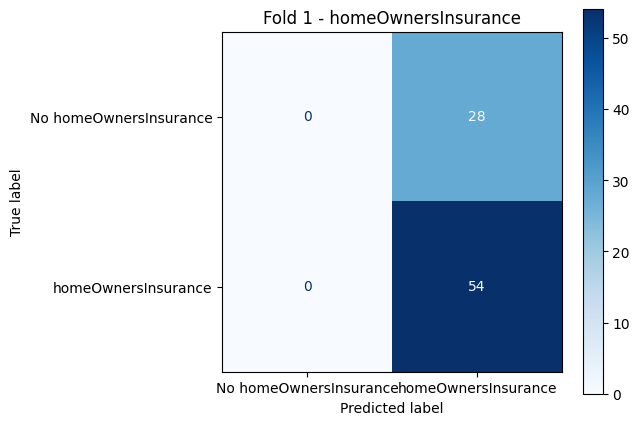

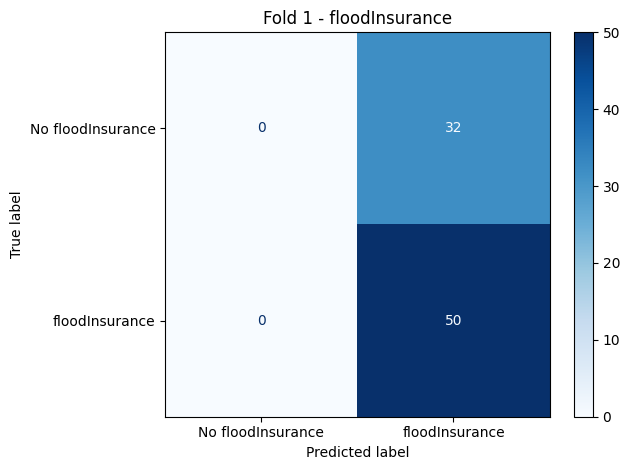

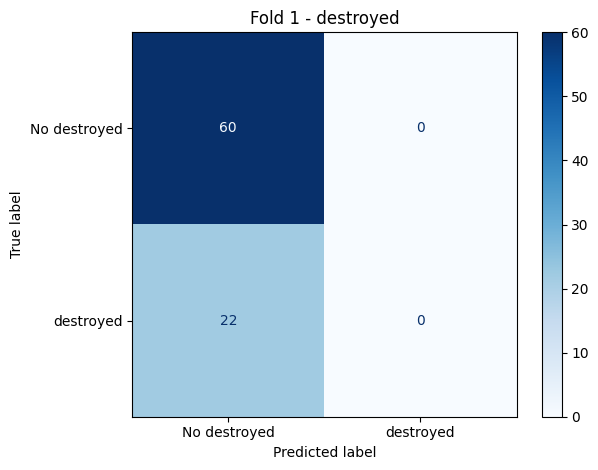

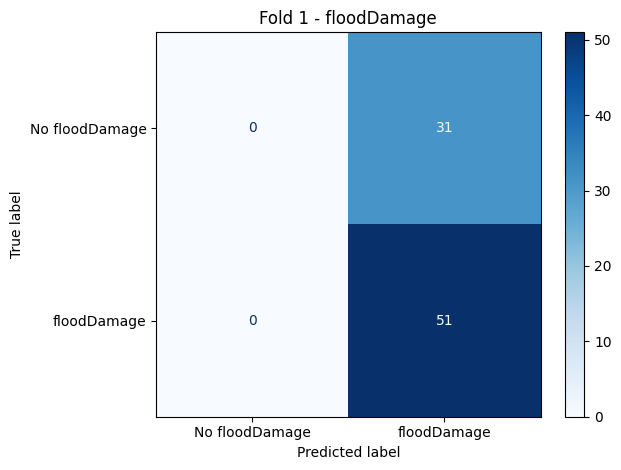

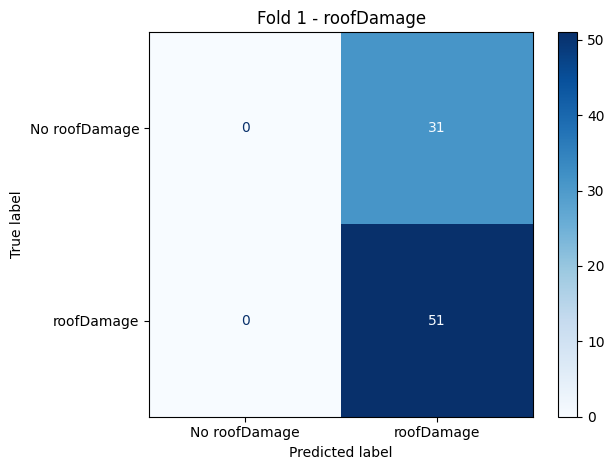

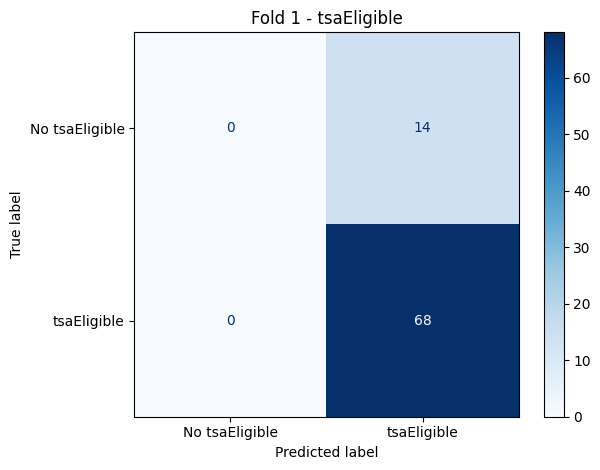

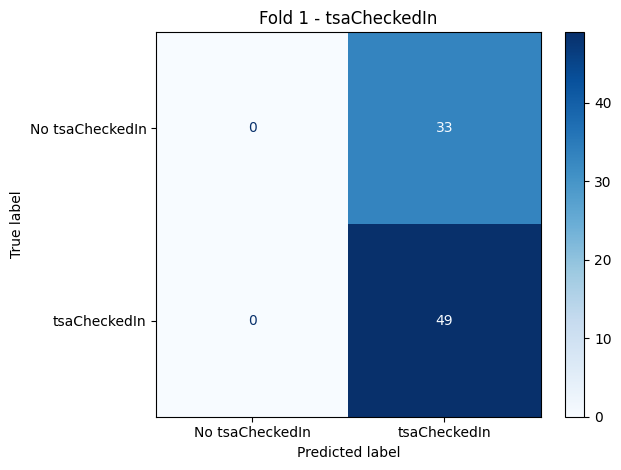

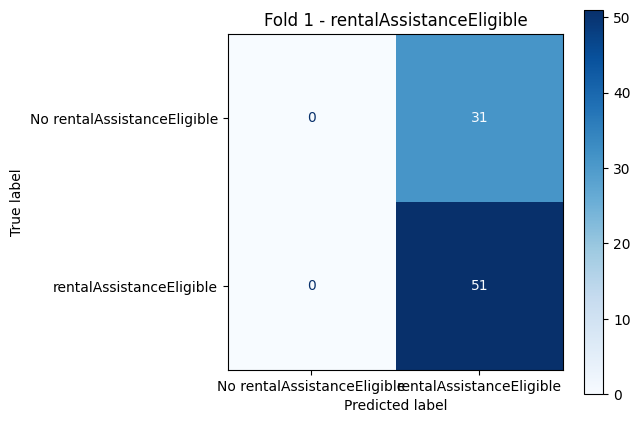

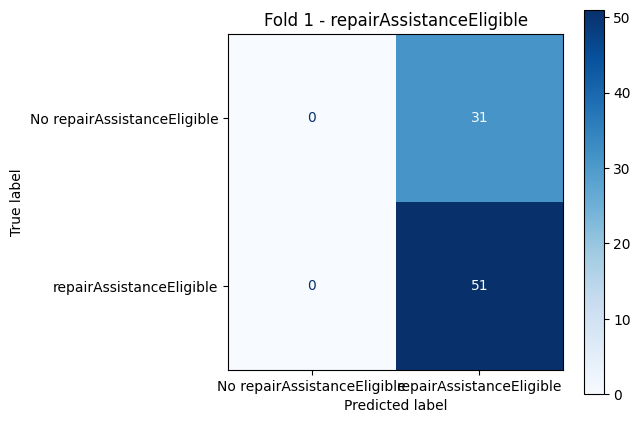

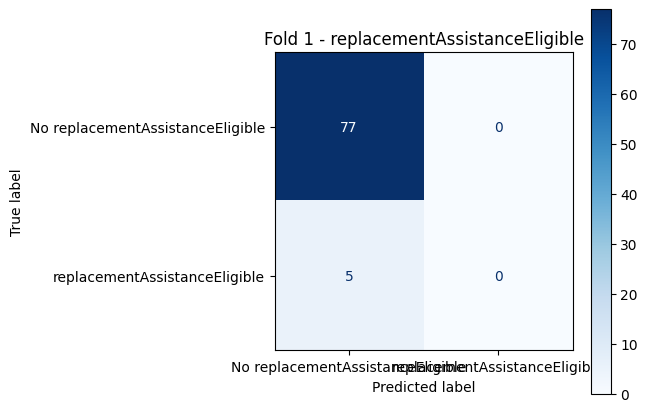

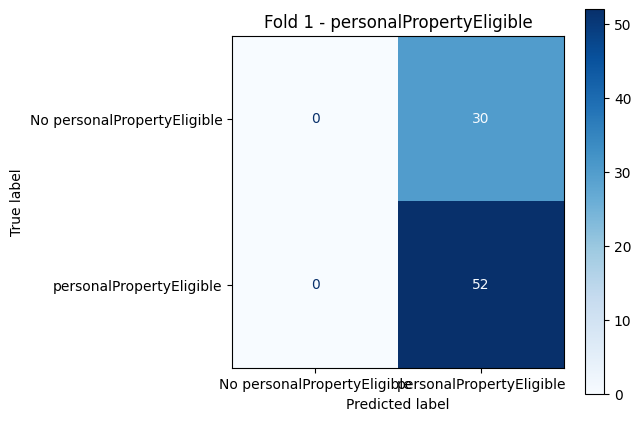


Evaluating fold 2...


/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)


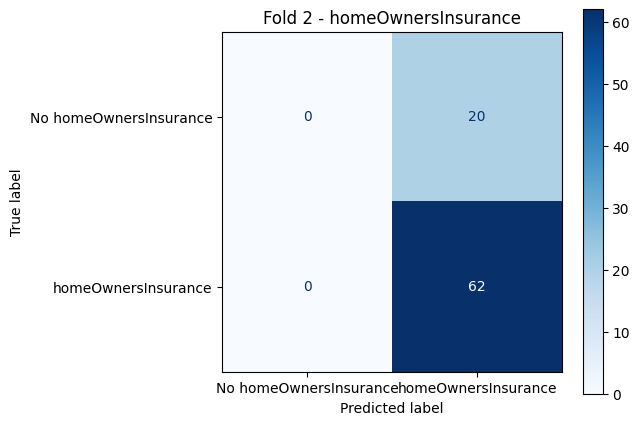

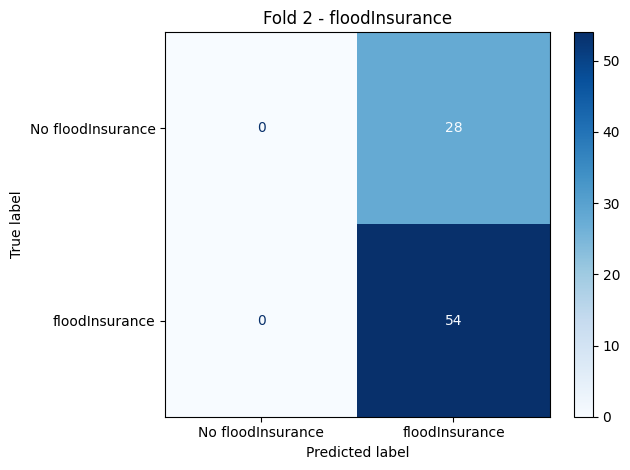

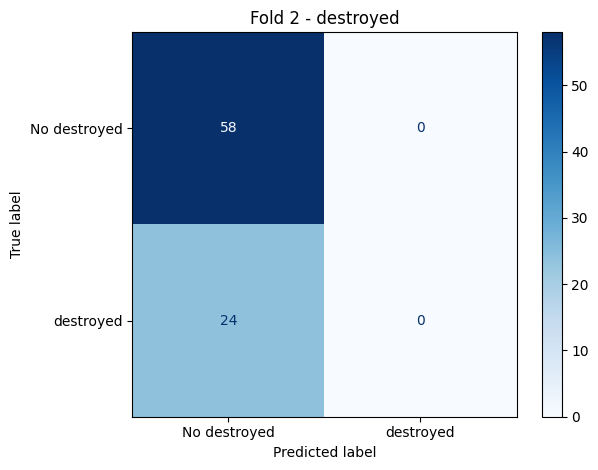

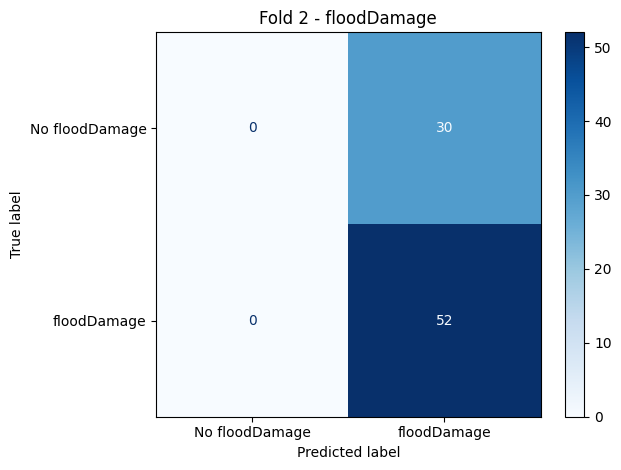

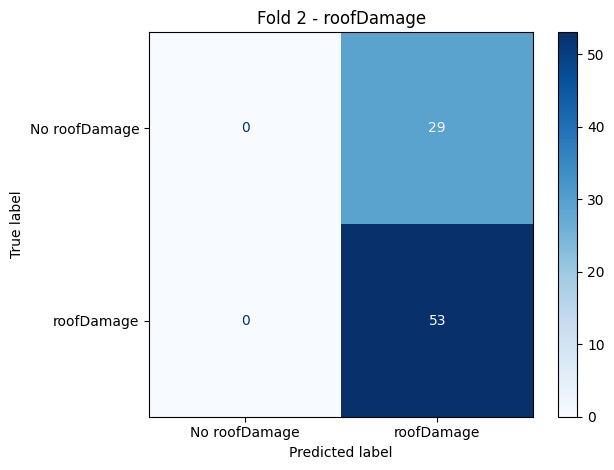

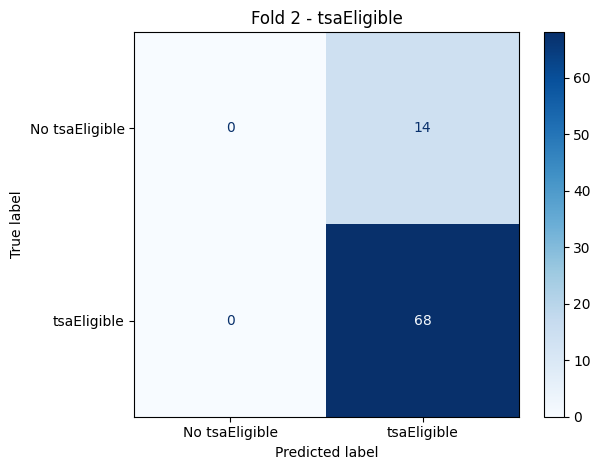

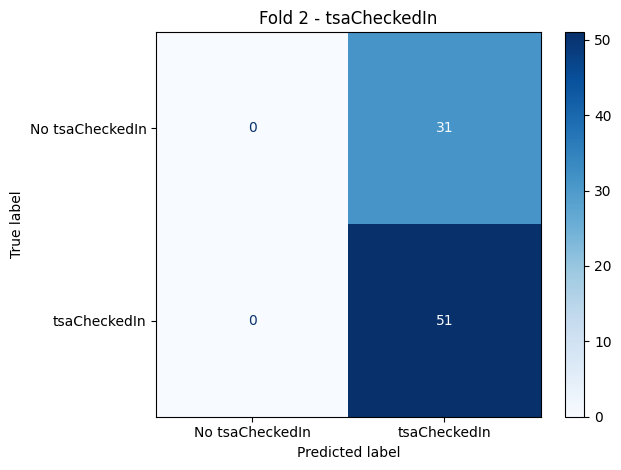

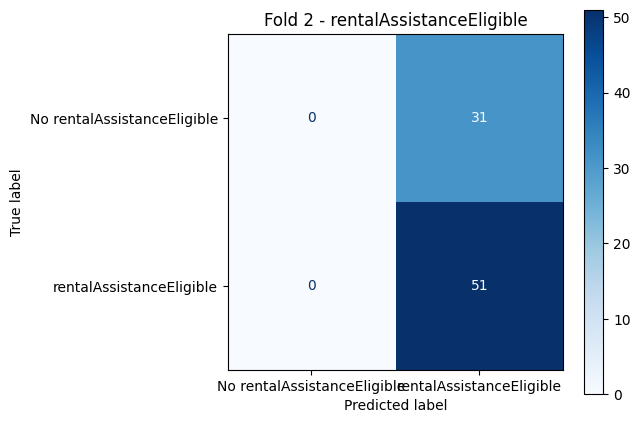

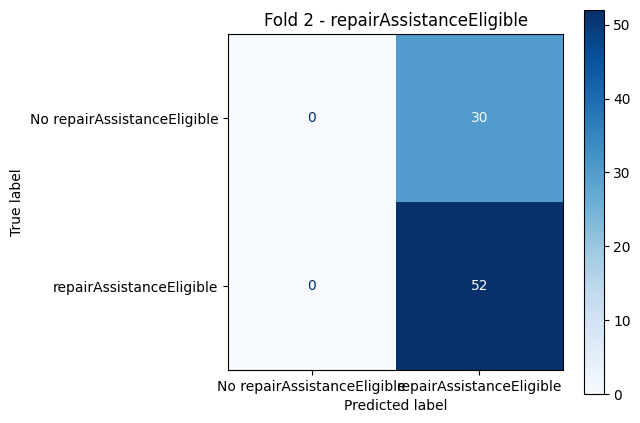

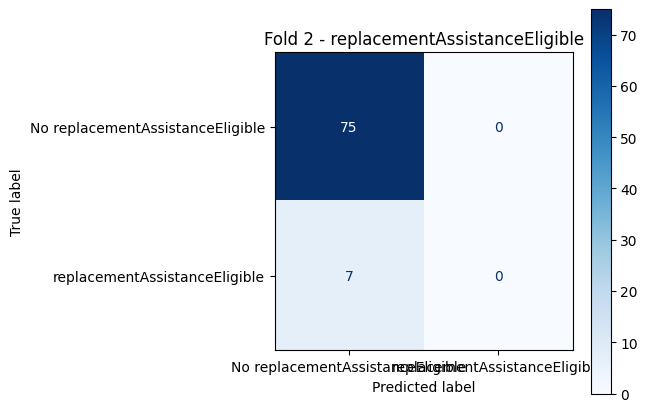

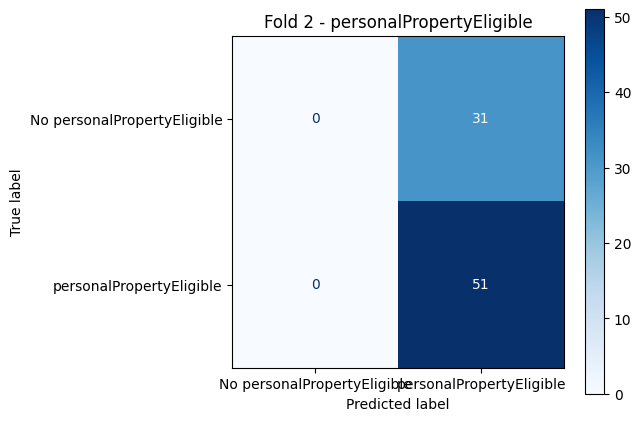


Evaluating fold 3...


/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)


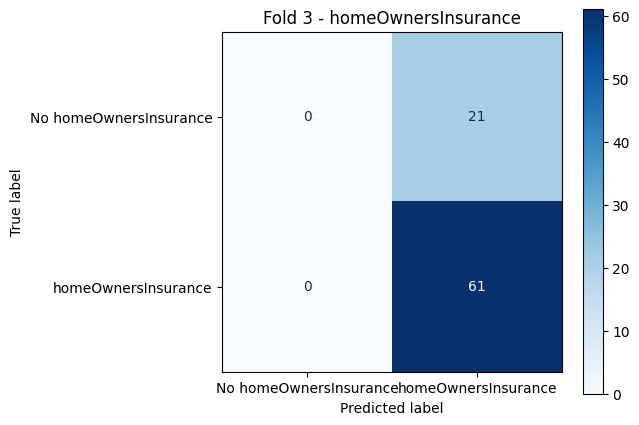

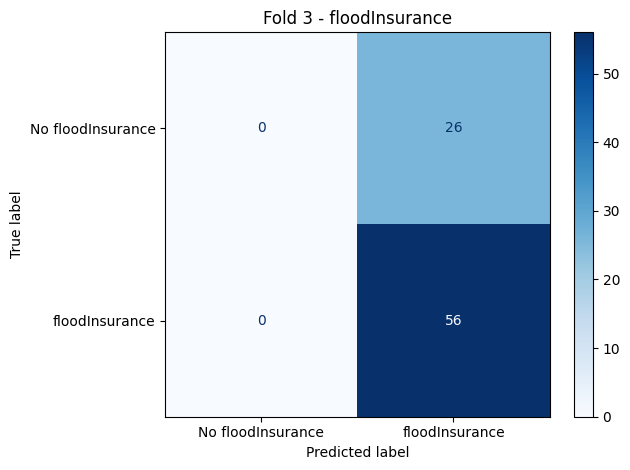

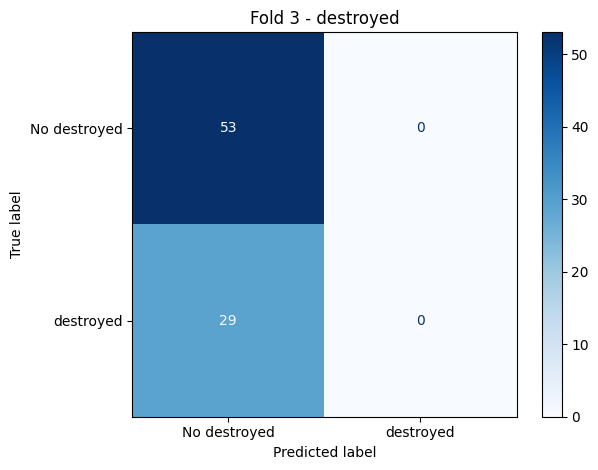

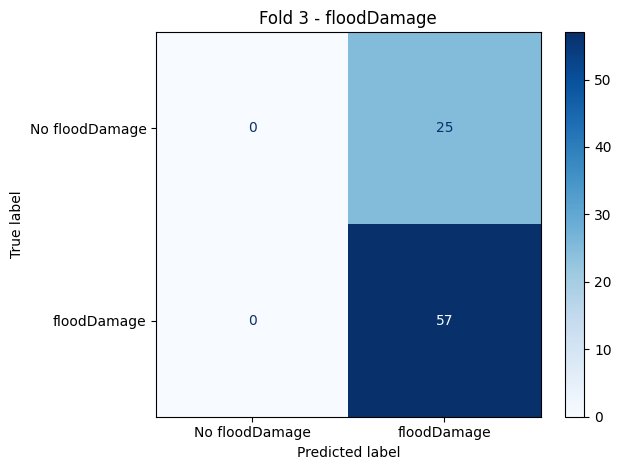

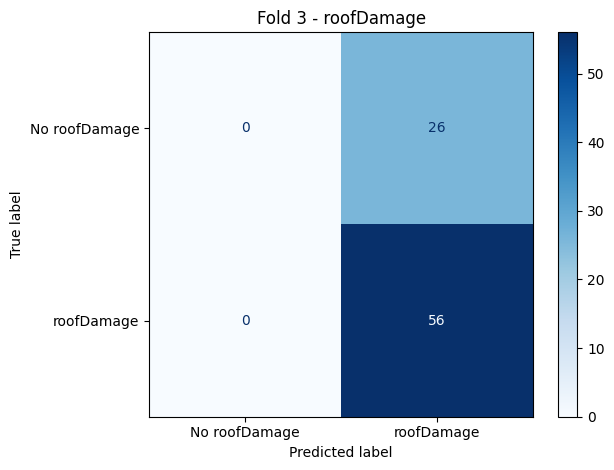

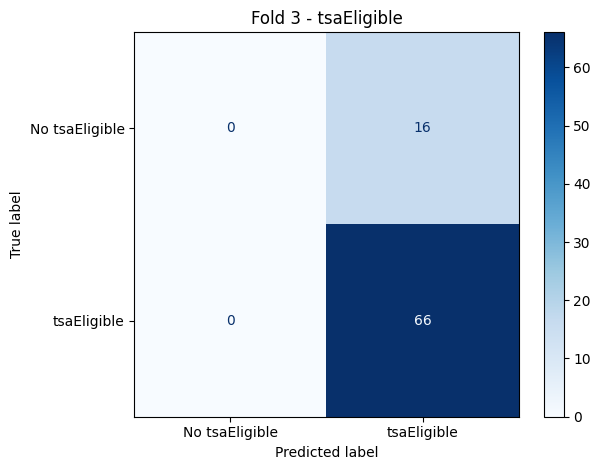

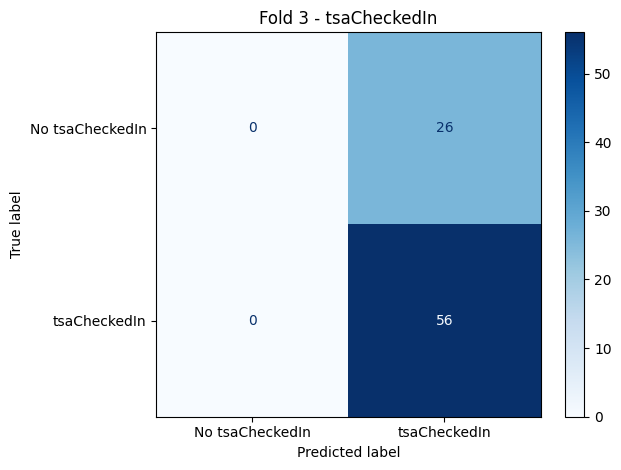

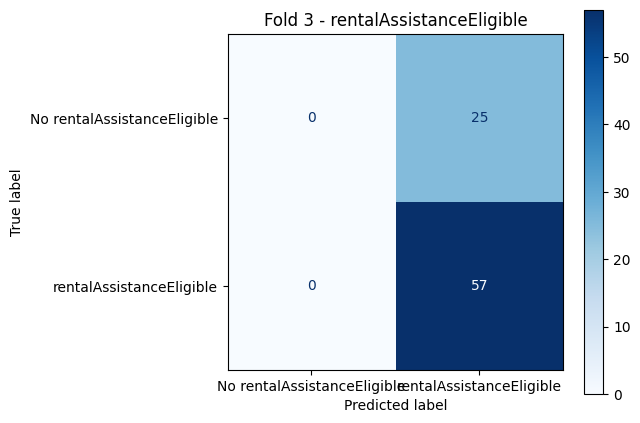

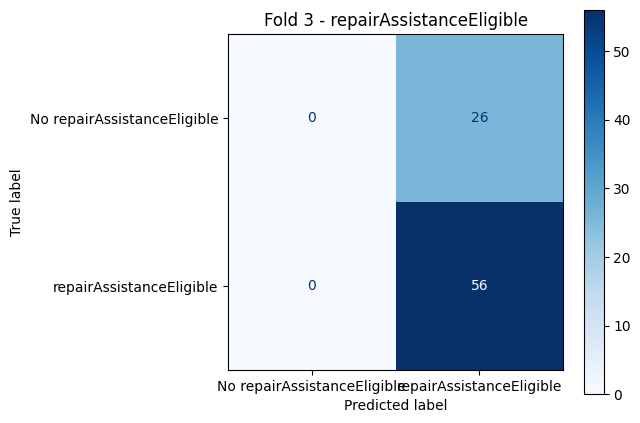

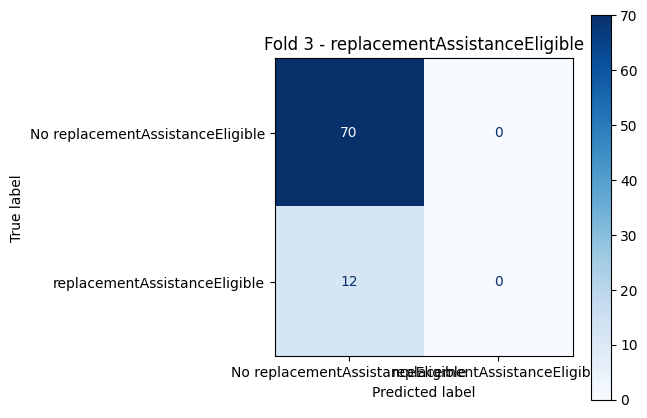

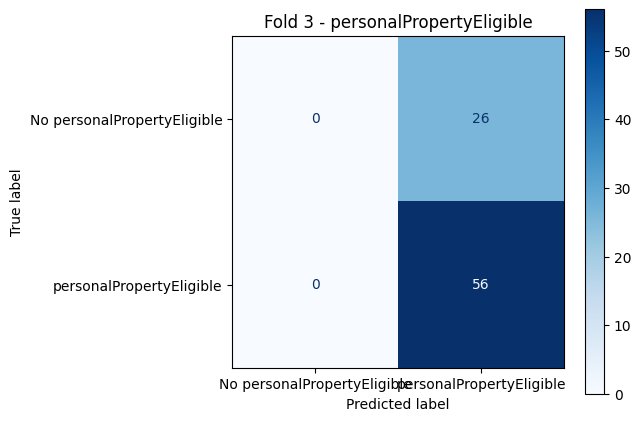


Evaluating fold 4...


/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)


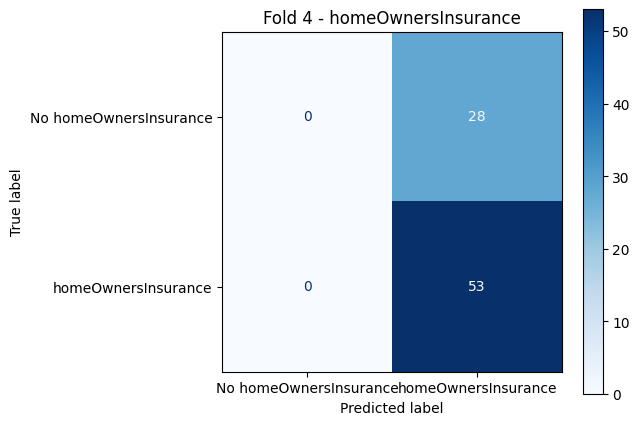

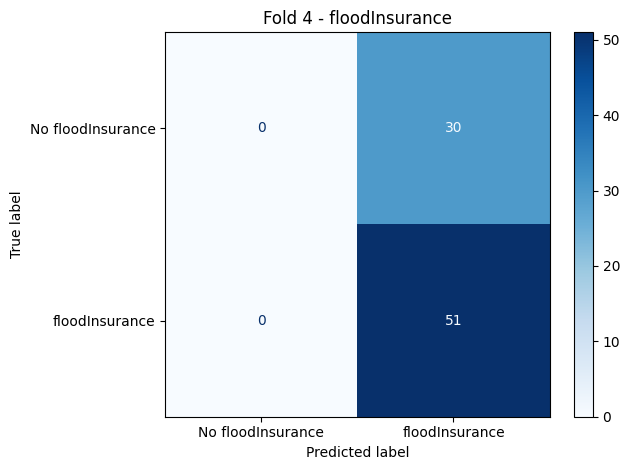

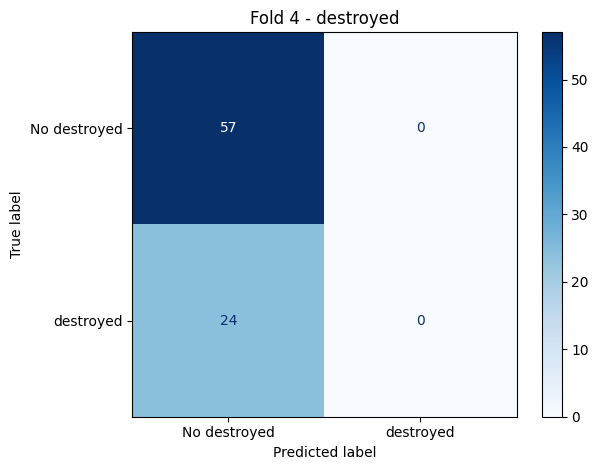

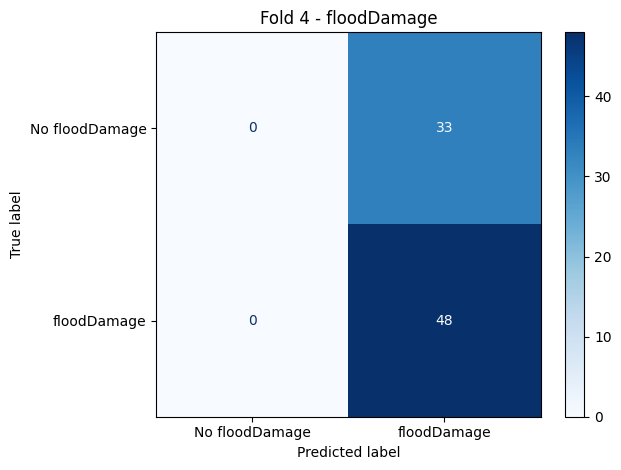

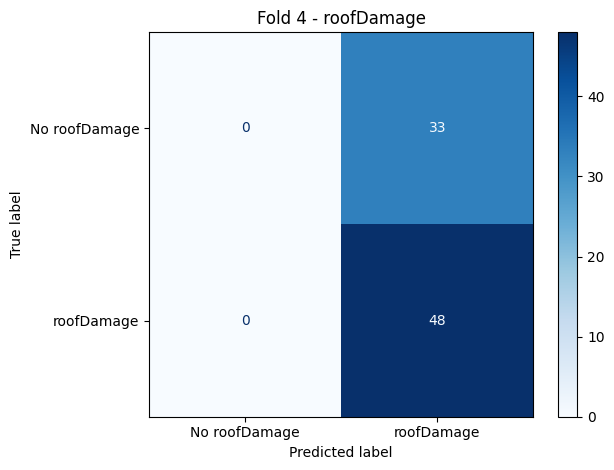

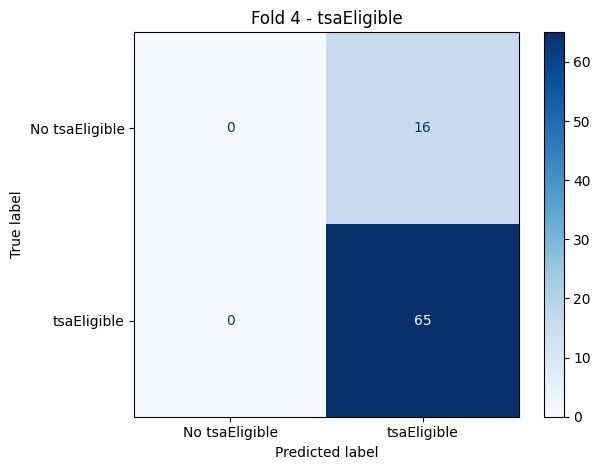

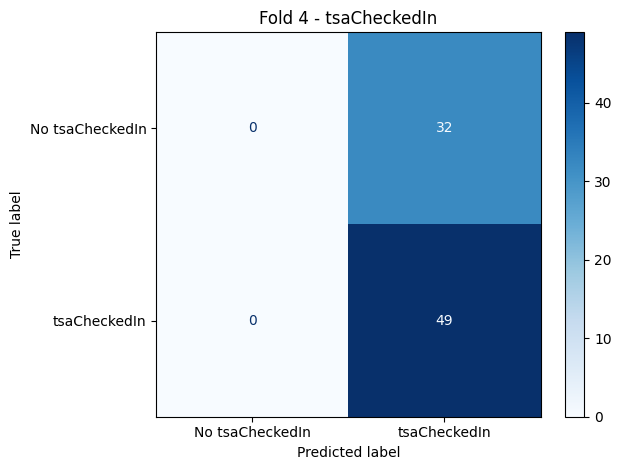

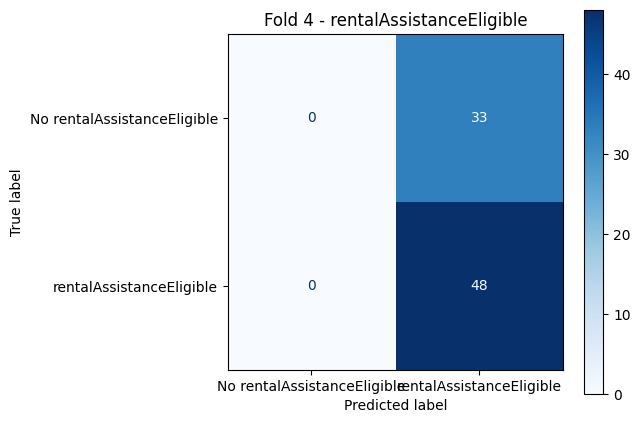

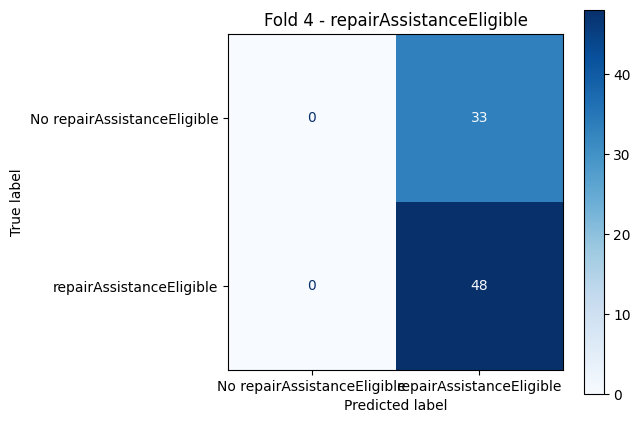

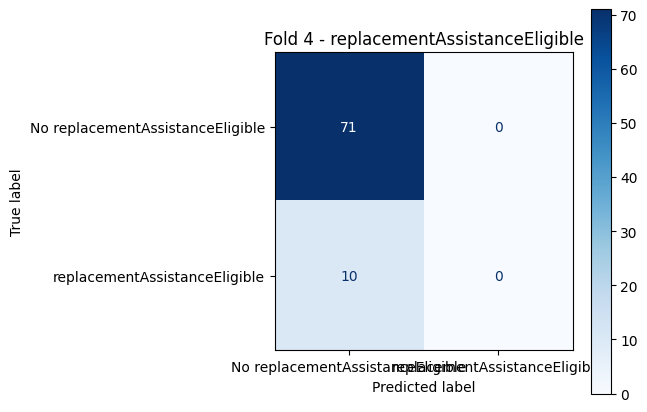

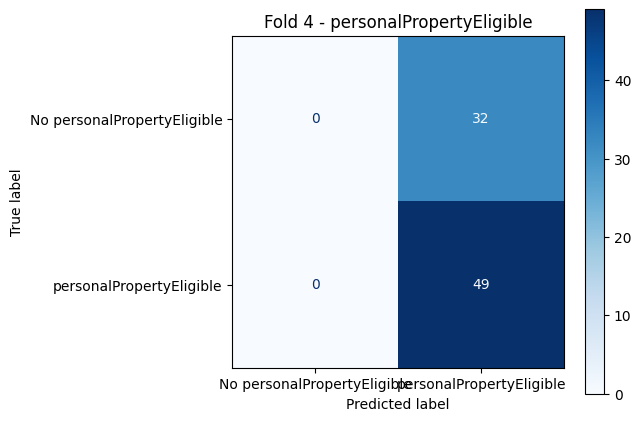


Evaluating fold 5...


/tmp/job.15628756/ipykernel_3227250/3335127068.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'labels': torch.tensor(label, dtype=torch.float32)


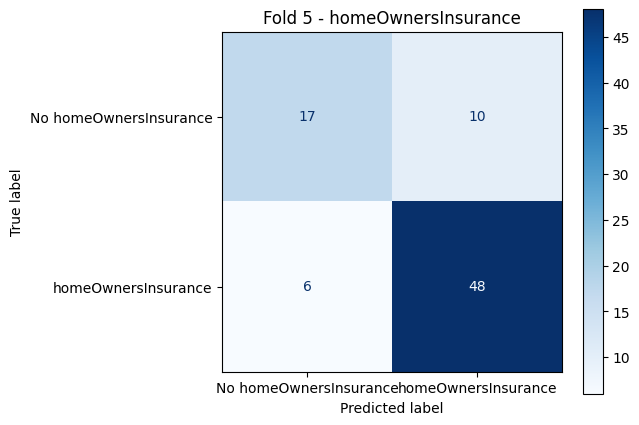

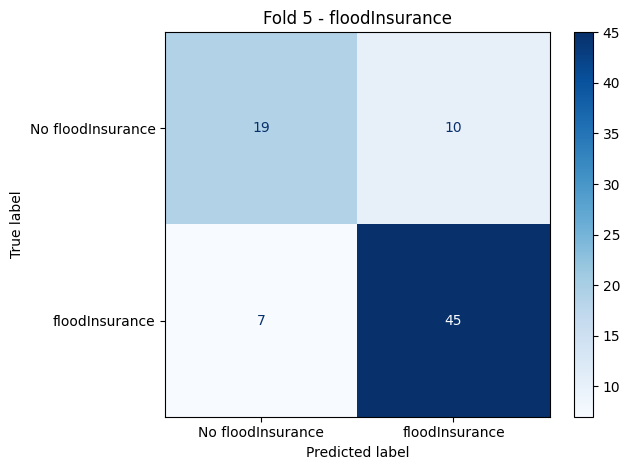

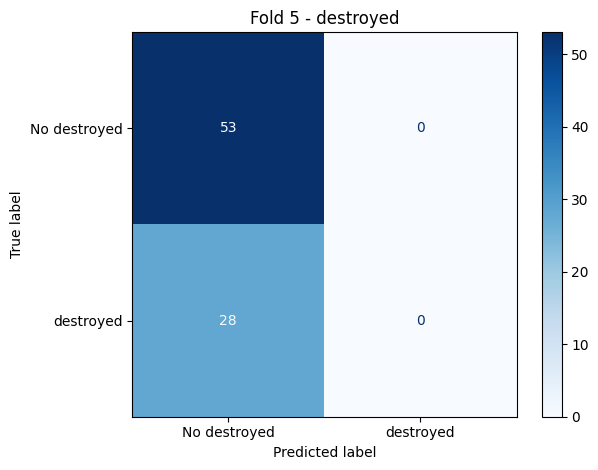

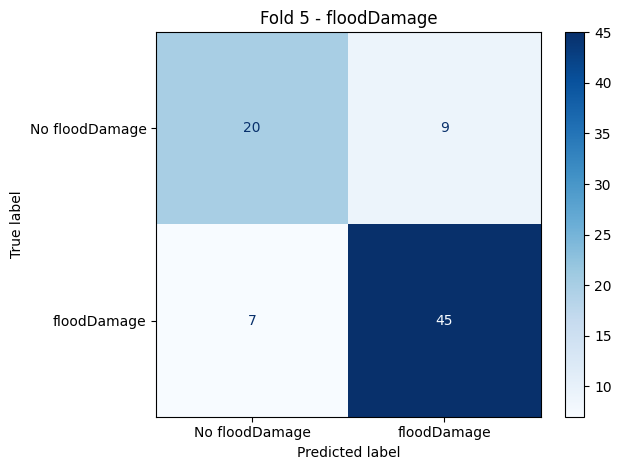

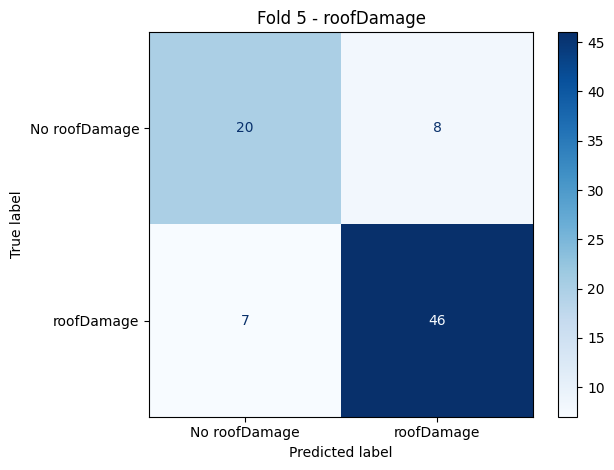

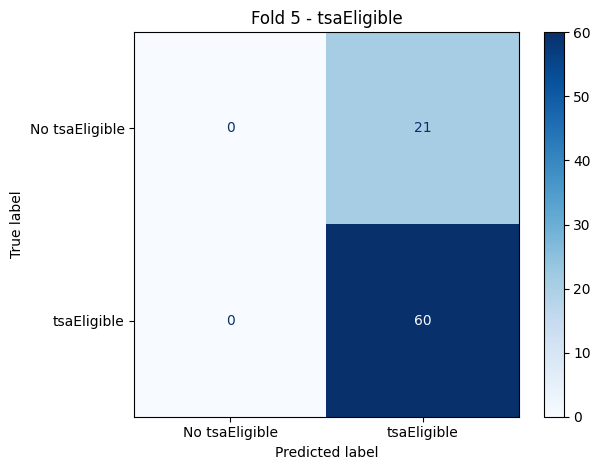

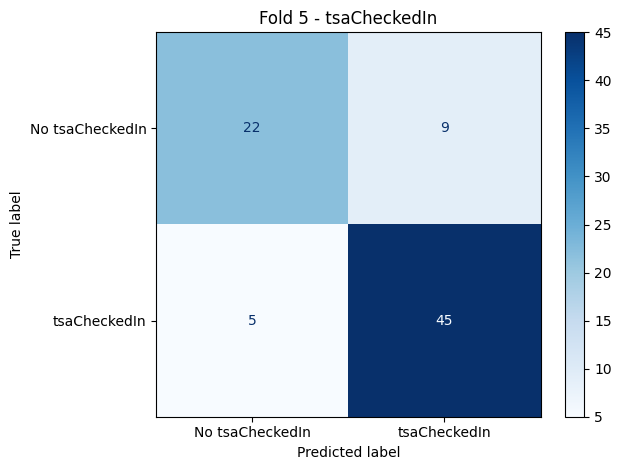

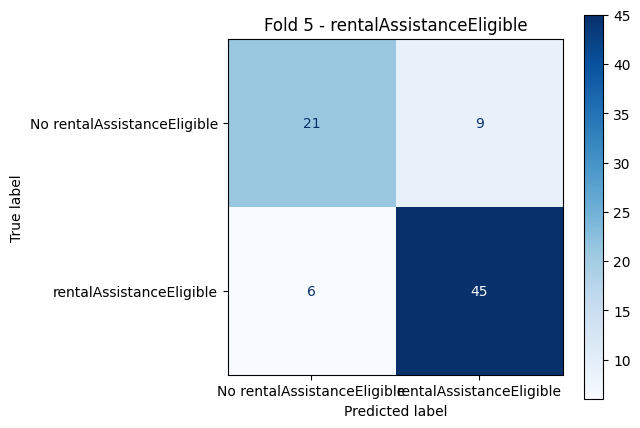

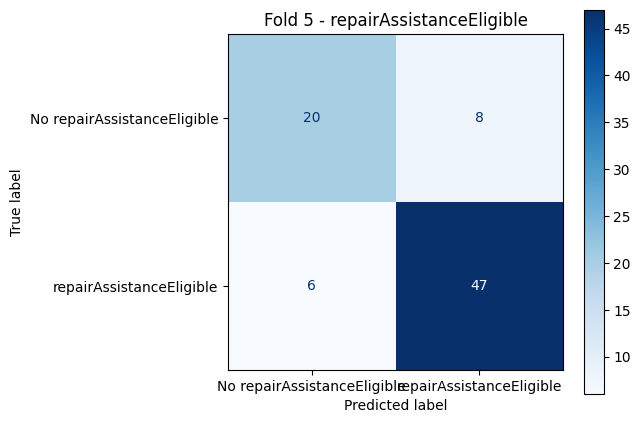

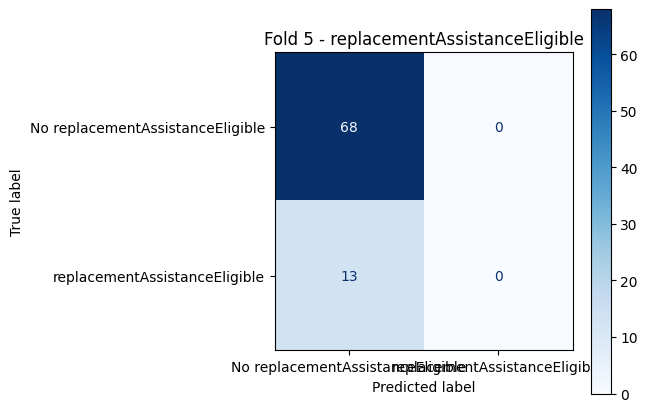

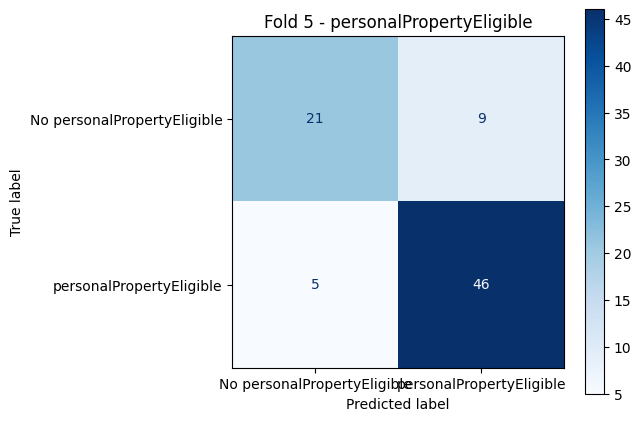

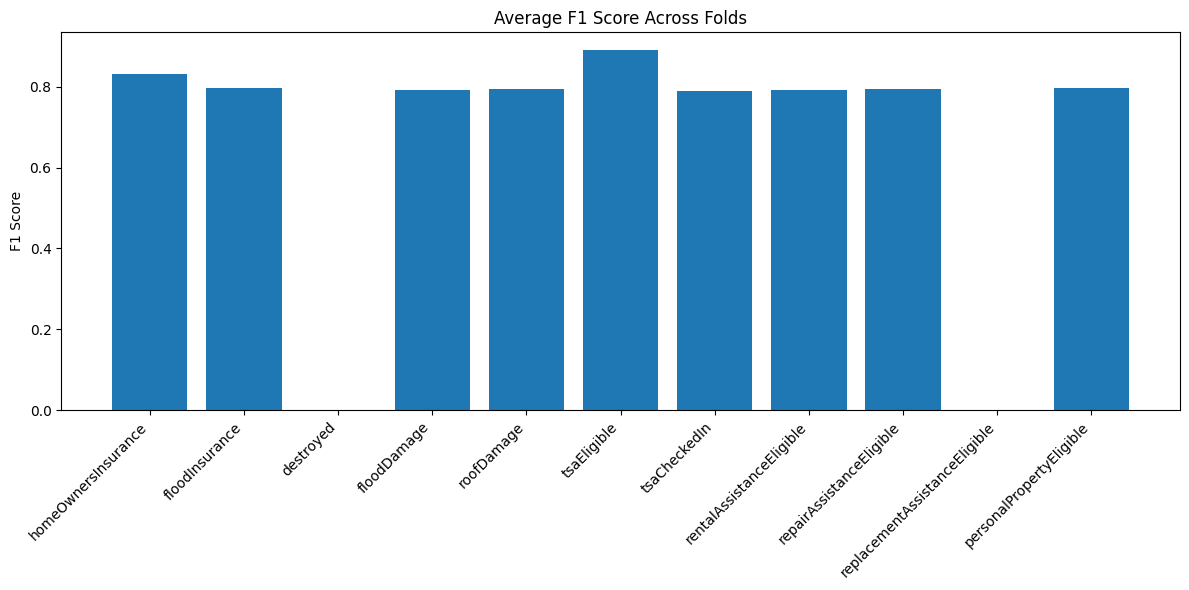

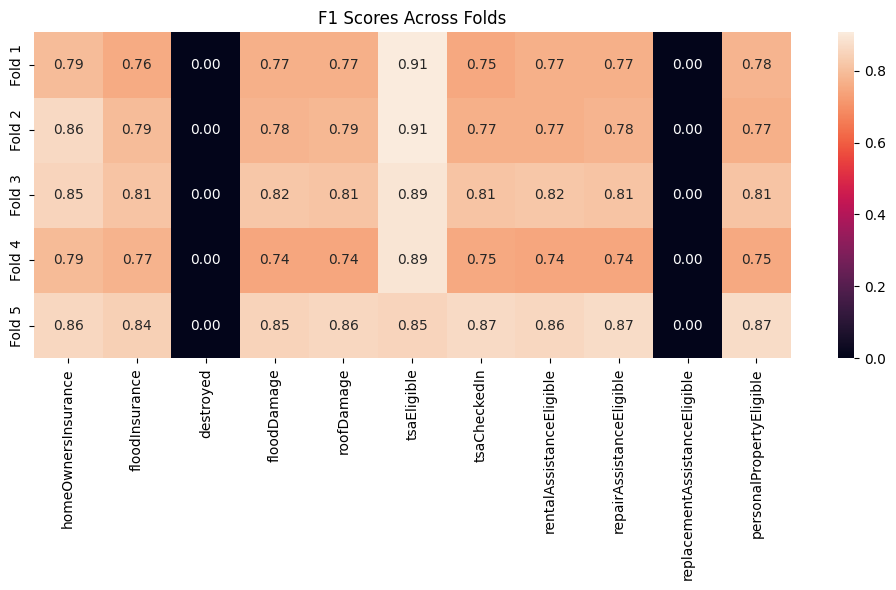

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_visualize(save_path, tweet_grouped, target_grouped, max_len=512):
    target_list = get_target_list()
    tweet_dict = {int(name): group['text'] for name, group in tweet_grouped}
    target_dict = {int(name): group[target_list] for name, group in target_grouped}

    intersecting_zips = list(set(tweet_dict.keys()) & set(target_dict.keys()))
    paired_data = {
        zipc: [target_dict[zipc].sum().apply(lambda x: 1 if x > 0 else 0), tweet_dict[zipc]]
        for zipc in intersecting_zips
    }

    texts = ['\n'.join(v[1].to_list()) for v in paired_data.values()]
    labels_ = [v[0] for v in paired_data.values()]
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    all_f1s, all_precisions, all_recalls = [], [], []

    for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(texts, labels_)):
        print(f"\nEvaluating fold {fold_idx + 1}...")

        model = BERTMultiDeepHeadClassifier(num_targets=len(target_list)).to(device)
        model_path = os.path.join(save_path, f"bert_model_fold_{fold_idx + 1}.pth")
        model.load_state_dict(torch.load(model_path))
        model.eval()

        test_texts = [texts[i] for i in test_idx]
        test_labels = [labels_[i] for i in test_idx]
        test_loader = DataLoader(CustomDataset(test_texts, test_labels, tokenizer, max_len), batch_size=16)

        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        preds = (np.vstack(all_preds) > 0.5).astype(int)
        true = np.vstack(all_labels)

        # Calculate metrics
        f1 = [f1_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]
        precision = [precision_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]
        recall = [recall_score(true[:, i], preds[:, i], zero_division=0) for i in range(len(target_list))]

        all_f1s.append(f1)
        all_precisions.append(precision)
        all_recalls.append(recall)

        # Confusion matrices
        conf_matrices = multilabel_confusion_matrix(true, preds)
        for i, cm in enumerate(conf_matrices):
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'No {target_list[i]}', f'{target_list[i]}'])
            disp.plot(cmap='Blues')
            plt.title(f'Fold {fold_idx + 1} - {target_list[i]}')
            plt.tight_layout()
            plt.show()

    # Summary plots
    all_f1s = np.array(all_f1s)
    avg_f1 = all_f1s.mean(axis=0)

    plt.figure(figsize=(12, 6))
    plt.bar(target_list, avg_f1)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('F1 Score')
    plt.title('Average F1 Score Across Folds')
    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(all_f1s, annot=True, fmt=".2f", xticklabels=target_list, yticklabels=[f"Fold {i+1}" for i in range(5)])
    plt.title("F1 Scores Across Folds")
    plt.tight_layout()
    plt.show()

# Run evaluation
evaluate_and_visualize(save_path, tweet_grouped_harvey, target_grouped_harvey, max_len=512)

- Loads saved models from each fold
- Computes and visualizes:
  - Confusion matrices for each label
  - Bar plot of average F1 scores
  - Heatmap of F1 scores across folds
- Helps analyze model performance per label and consistency across folds